# Birth dates

### information about the associated study

Levy, B. R., Chung, P. H., & Slade, M. D. (2011). [Influence of Valentine’s Day and Halloween on birth timing](https://andrewgelman.com/wp-content/uploads/2012/02/halloween.pdf). Social Science & Medicine, 73(8), 1246-1248.

![alt](https://andrewgelman.com/wp-content/uploads/2012/02/Screen-shot-2012-02-14-at-8.06.17-AM.png)

## imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#### set defaults

In [2]:
sns.set_style('ticks')
sns.set_context('poster')

## load data

In [3]:
#df = pd.read_csv('../data/birthdates-1968-1988.csv')
df = pd.read_csv('../data/births.csv')

In [4]:
df.tail()

,month,day,births
367,12,27,194006
368,12,28,201768
369,12,29,204806
370,12,30,206894
371,12,31,194368


## clean data

In [5]:
df.shape

(372, 3)

In [6]:
clean_df = df[df.loc[:,'births']>150000]

In [7]:
clean_df.shape

(365, 3)

## transform data

Number each day as the differente relative to Valentine's day (with Valentine's day itself at zero)

In [39]:
valentine_df = clean_df[clean_df.loc[:,'month']==2]
valentine_df.loc[:,'zero day'] = (valentine_df.loc[:,'day']-14)

/home/brain/.conda/envs/abbildungen/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/brain/.conda/envs/abbildungen/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
valentine_df

,month,day,births,zero day
31,2,1,186458,-13
32,2,2,189721,-12
33,2,3,190473,-11
34,2,4,190433,-10
35,2,5,189132,-9
36,2,6,187124,-8
37,2,7,185986,-7
38,2,8,186741,-6
39,2,9,188543,-5
40,2,10,192034,-4


## model

Number of births for each daay, relative to Valentine's day.

In [45]:
valentine_births = valentine_df.loc[44,'births']
valentine_births

194510

In [46]:
valentine_df.loc[:,'diffs'] = (valentine_df.loc[:,'births']-valentine_births)

/home/brain/.conda/envs/abbildungen/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/brain/.conda/envs/abbildungen/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
valentine_df.tail()

,month,day,births,zero day,diffs
54,2,24,193160,10,-1350
55,2,25,194281,11,-229
56,2,26,191623,12,-2887
57,2,27,187750,13,-6760
58,2,28,187812,14,-6698


## visualize

In [48]:
x = valentine_df.loc[44-7:44+7,'zero day']
y = valentine_df.loc[44-7:44+7,'diffs']

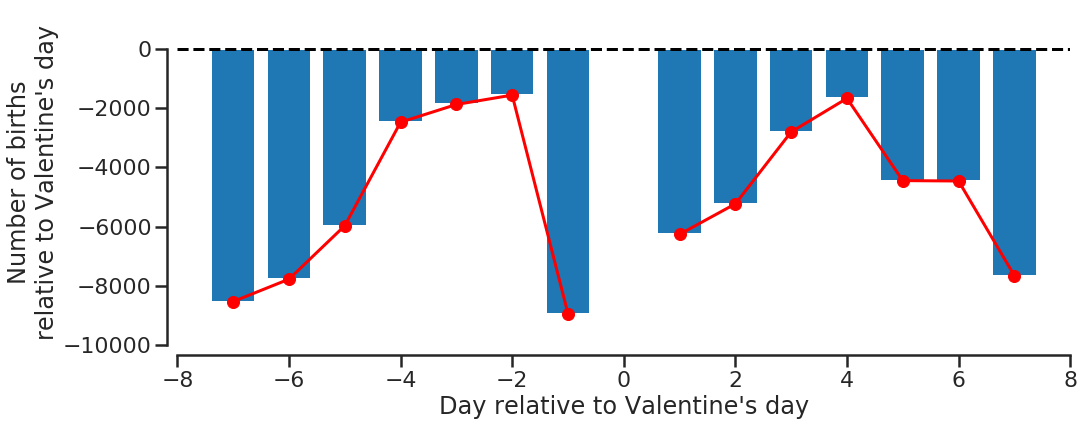

In [61]:
plt.figure(figsize=(16,6))
plt.bar(x,y)
plt.plot(x[:7],y[:7],'-o',color='r')
plt.plot(x[8:],y[8:],'-o',color='r')
plt.xlim(-8,8)
plt.xlabel("Day relative to Valentine's day")
plt.ylim(-10000,1000)
plt.ylabel("Number of births\nrelative to Valentine's day")
plt.axhline(0,linestyle='dashed',color='k')
sns.despine(trim=True,offset=10)
plt.show()

## maiking sense of the data

All days around Valentine's day have fewer births than Valentine's day itself.

## To be continued ..?

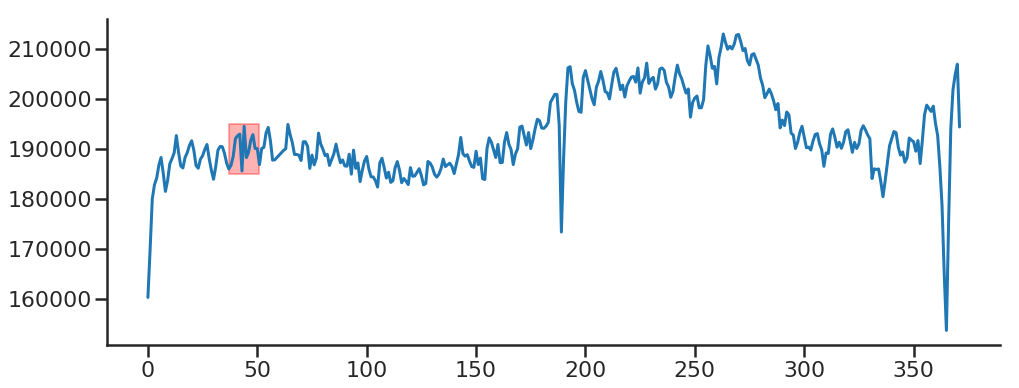

In [50]:
plt.figure(figsize=(16,6))
plt.plot(clean_df.loc[:,'births'])
plt.fill_between([44-7,44+7],[185000,185000],[195000,195000],color='r',alpha=0.3)
sns.despine()
plt.show()